# 【全人類がわかるE資格コース PyTorch版】 プロダクト開発演習
## 7. YOLACT　model検証


公開されているLaboro Tomato Datasetを使い、別の特徴を持つYOLACTモデルにて、インスタンス・セグメンテーションの検証を行う。  
Mask R-CNNモデルと比較し、YOLACTモデルは判定(infelence)速度が速く、条件次第では30fpsを上回るとされている。もしもその速度がエッジデバイスでも出るのであれば、WebCamからの動画入力に対して、ローカルにリアルタイムでセグメンテーション、クラス判定が行えると期待できるため、今回比較対象として取り上げる。

In [1]:
# Google Driveのマウント
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 7.1 mmdetection v2.23.0 のインストール（google Colab版）
https://github.com/open-mmlab/mmdetection/blob/master/demo/MMDet_Tutorial.ipynb


In [2]:
# pritrainモデルの動作確認
# MMDetctionのインストール
# Check nvcc version = NVIDIA cuda compiler version
!nvcc -V
# Check GCC version
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [3]:
# ************** こちらは旧バージョンをロード　v2.24.0～最新版v2.25.0 では学習(tools/train.py)時Error発生のため*******************

# 関係ファイルのインストール(旧バージョン用)
# install dependencies: (use cu111 because colab has CUDA 11.1)
!pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html

# install mmcv-full thus we could use CUDA operators
### !pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.9.0/index.html
### バージョンv2.25.0ではAttributeError: 'ConfigDict' object has no attribute 'device'が発生するので
###  mmdetection v.2.23.0を使用するため、それに合わせてmmcvも1.5.x から1.3.17にダウングレード
!pip install mmcv-full==1.3.17 -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.9.0/index.html    ### for Error
# Install mmdetection
!rm -rf mmdetection
### !git clone https://github.com/open-mmlab/mmdetection.git
### mmdetection 最新バージョンv2.25.0ではtools/train.pyに問題があり、
### AttributeError: 'ConfigDict' object has no attribute 'device'が発生するので、回避策としてv2.23.0にバージョンを戻す
!git clone https://github.com/open-mmlab/mmdetection.git -b v2.23.0 --depth 1    ### for Error
%cd mmdetection

!pip install -e .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |█████████████                   | 834.1 MB 1.3 MB/s eta 0:15:10tcmalloc: large alloc 1147494400 bytes == 0x3a392000 @  0x7f2475cd6615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |████████████████▌               | 1055.7 MB 1.4 MB/s eta 0:12:10tcmalloc: large alloc 1434370048 bytes == 0x7e9e8000 @  0x7f2475cd6615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |█████

In [4]:
# インストール環境の確認
from mmcv import collect_env
collect_env()

{'CUDA available': True,
 'CUDA_HOME': '/usr/local/cuda',
 'GCC': 'gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0',
 'GPU 0': 'Tesla P100-PCIE-16GB',
 'MMCV': '1.3.17',
 'MMCV CUDA Compiler': '11.1',
 'MMCV Compiler': 'GCC 7.3',
 'NVCC': 'Build cuda_11.1.TC455_06.29190527_0',
 'OpenCV': '4.1.2',
 'PyTorch': '1.9.0+cu111',
 'PyTorch compiling details': 'PyTorch built with:\n  - GCC 7.3\n  - C++ Version: 201402\n  - Intel(R) Math Kernel Library Version 2020.0.0 Product Build 20191122 for Intel(R) 64 architecture applications\n  - Intel(R) MKL-DNN v2.1.2 (Git Hash 98be7e8afa711dc9b66c8ff3504129cb82013cdb)\n  - OpenMP 201511 (a.k.a. OpenMP 4.5)\n  - NNPACK is enabled\n  - CPU capability usage: AVX2\n  - CUDA Runtime 11.1\n  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_70,code=sm_70;-gencode;arch=compute_75,code=sm_75;-gencode;arch=compute_80,code=sm_80;-gencode;arch=compute_86,code=sm_8

In [5]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMDetection installation
import mmdet
print(mmdet.__version__)

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

1.9.0+cu111 True
2.23.0
11.1
GCC 7.3


## 7.2 YOLACTモデルでの学習、評価・検証

### YOLACT r50 1x8 COCOモデル

Laboro Tomato dataset（ローカルコピーしたもの）を、google DriveからMMdetectionの実行環境にコピー（シンボリックリンク）  
MMDetectionフレームワークで利用できるようモデルの環境設定(config）を、LaboroTomatoの公開情報とMMDetectionのチュートリアルを参考に変更する。  

In [6]:
# laboro_tomato datasetを./data/にシンボリックリンクをコピー
!cd '/content/mmdetection'
!mkdir -p ./data
!ln -s '/content/drive/MyDrive/Colab Notebooks/product_develop/laboro_tomato' './data/laboro_tomato'

In [7]:
# datasets annotation coco format JSONファイルの確認（training用、test用）
# laboro_tomato/annotations/train.json laboro_tomato/annotations/test.json

!cd /content/mmdetection/
!ls -al ./data
print('\n/content/drive/MyDrive/Colab Notebooks/product_develop/laboro_tomato')
!ls -al '/content/drive/MyDrive/Colab Notebooks/product_develop/laboro_tomato'

total 12
drwxr-xr-x  2 root root 4096 Jun 25 06:26 .
drwxr-xr-x 17 root root 4096 Jun 25 06:26 ..
lrwxrwxrwx  1 root root   68 Jun 25 06:26 laboro_tomato -> '/content/drive/MyDrive/Colab Notebooks/product_develop/laboro_tomato'

/content/drive/MyDrive/Colab Notebooks/product_develop/laboro_tomato
total 16
drwx------ 2 root root 4096 Jun 14 09:16 annotations
drwx------ 2 root root 4096 Jun 17 09:54 .ipynb_checkpoints
drwx------ 2 root root 4096 Jun 14 09:16 test
drwx------ 2 root root 4096 Jun 14 09:16 train


In [9]:
# Add datasets to mmdetection
!cp '/content/drive/MyDrive/Colab Notebooks/product_develop/yolact_tomato_etc/laboro_tomato.py'\
    './mmdet/datasets/laboro_tomato.py'

# Add dataset names to mmdet/datasets/__init__.py
!cp '/content/drive/MyDrive/Colab Notebooks/product_develop/yolact_tomato_etc/__init__tomato.py'\
    './mmdet/datasets/__init__.py'

# step3: overwrite class numbers at model configuration file configs/yolact/yolact_r50_1x8_coco.py
!cp '/content/drive/MyDrive/Colab Notebooks/product_develop/yolact_tomato_etc/yolact_r50_1x8_coco_tomato.py'\
    './configs/yolact/yolact_r50_1x8_coco_tomato.py'


In [11]:
# configの切り替え  to YOLACTモデルへ
# a yolact model achieving 29 mAP on MS COCO at 42.5 fps evaluated on a single GPU model.
# yolact_r50_1x8_coco.py [Enhance]: Optimize augmentation pipeline to speed up training. (#6442)

from mmcv import Config

cfg = Config.fromfile('configs/yolact/yolact_r50_1x8_coco_tomato.py')

# download the pre-trained checkpoints for inference and finetuning.
!mkdir -p checkpoints
!wget -c https://download.openmmlab.com/mmdetection/v2.0/yolact/yolact_r50_1x8_coco/yolact_r50_1x8_coco_20200908-f38d58df.pth \
      -O checkpoints/yolact_r50_1x8_coco_20200908-f38d58df.pth

--2022-06-25 06:28:02--  https://download.openmmlab.com/mmdetection/v2.0/yolact/yolact_r50_1x8_coco/yolact_r50_1x8_coco_20200908-f38d58df.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.88.36.72
Connecting to download.openmmlab.com (download.openmmlab.com)|47.88.36.72|:443... connected.
HTTP request sent, awaiting response... 200 OK

    The file is already fully retrieved; nothing to do.



In [12]:
# modelのコンフィグレーション
from mmdet.apis import set_random_seed

# Modify dataset type and path
### cfg.dataset_type = 'LaboroTomato'

### cfg.data.test.ann_file = 'data/laboro_tomato/annotation/test.json'
### cfg.data.test.img_prefix = 'data/laboro_tomato/test/'
### cfg.data.test.classes = ('LaboroTomato',)

### cfg.data.train.ann_file = 'data/laboro_tomato/annotation/train.json'
### cfg.data.train.img_prefix = 'data/laboro_tomato/train/'
### cfg.data.train.classes = ('LaboroTomato',)

### cfg.data.val.ann_file = 'data/laboro_tomato/annotation/test.json'
### cfg.data.val.img_prefix = 'data/laboro_tomato/test/'
### cfg.data.val.classes = ('LaboroTomato',)

# modify num classes of the model in box head and mask head
### cfg.model.bbox_head.num_classes = 6
### cfg.model.mask_head.num_classes = 6
### cfg.model.segm_head.num_classes = 6

# We can still the pre-trained Mask RCNN model to obtain a higher performance
###cfg.load_from = 'checkpoints/yolact_r50_1x8_coco_20200908-f38d58df.pth'

# Set up working dir to save files and logs.
#cfg.work_dir = ./data/laboro_tomato

# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
### cfg.optimizer.lr = 0.02 / 8
### cfg.optimizer.lr = 0.01
### cfg.lr_config.warmup = None
### cfg.log_config.interval = 10

### add by Fujiwara
### cfg.runner.max_epochs=48

# We can set the evaluation interval to reduce the evaluation times
cfg.evaluation.interval = 12
# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 12

# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# We can also use tensorboard to log the training process
cfg.log_config.hooks = [
    dict(type='TextLoggerHook'),
    dict(type='TensorboardLoggerHook')]

# We can initialize the logger for training and have a look
# at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
checkpoint_config = dict(interval=12)
log_config = dict(
    interval=50,
    hooks=[dict(type='TextLoggerHook'),
           dict(type='TensorboardLoggerHook')])
custom_hooks = [dict(type='NumClassCheckHook')]
dist_params = dict(backend='nccl')
log_level = 'INFO'
load_from = 'checkpoints/yolact_r50_1x8_coco_20200908-f38d58df.pth'
resume_from = None
workflow = [('train', 1)]
opencv_num_threads = 0
mp_start_method = 'fork'
img_size = 550
model = dict(
    type='YOLACT',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=-1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=False,
        zero_init_residual=False,
        style='pytorch',
        init_cfg=dict(type='Pretrained', checkpoint='torchvision://resnet50')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        start_level=1,
        add_extra_convs='on_inp

## 7.3 train dataによる学習の実行

In [13]:
# カスタマイズしたDetectorの学習　train

# Trains using the resnet-50 backbone with a batch size of 8 on a single GPU.
!./tools/dist_train.sh configs/yolact/yolact_r50_1x8_coco_tomato.py 1

## single-gpu train

# !python tools/train.py ./configs/yolact/yolact_r50_1x8_coco_tomato.py \
#                       --work-dir ./laboro_tomato


/usr/local/lib/python3.7/dist-packages/torch/distributed/launch.py:164: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead
  "The module torch.distributed.launch is deprecated "
The module torch.distributed.launch is deprecated and going to be removed in future.Migrate to torch.distributed.run
 Please read local_rank from `os.environ('LOCAL_RANK')` instead.
INFO:torch.distributed.launcher.api:Starting elastic_operator with launch configs:
  entrypoint       : ./tools/train.py
  min_nodes        : 1
  max_nodes        : 1
  nproc_per_node   : 1
  run_id           : none
  rdzv_backend     : static
  rdzv_endpoint    : 127.0.0.1:29500
  rdzv_configs     : {'rank': 0, 'timeout': 900}
  max_restarts     : 3
  monitor_interval : 5
  log_dir          : None
  metrics_cfg      : {}

INFO:torch.distributed.elastic.agent.server.local_elastic_agent:log directory set to: /tmp/torchelastic_x198_l4o/none_4hgehydz
INFO:torch.distributed.elastic.agent.server.api:[default] star

In [ ]:
# load tensorboard in colab
%load_ext tensorboard

# see curves in tensorboard
%tensorboard --logdir ./laboro_tomato

## 7.4 test dataによるYOLACT学習modelの正当性確認 
学習中Epoch2まで完了の後、Epoch3途中で google ColabのRun Timeエラー発生！！  
エラー発生前のEpch 2までの学習結果をtestデータを使い評価する。
このためconfigデータを書き換える

In [18]:
# overwrite class numbers at model configuration file configs/yolact/yolact_r50_1x8_coco.py
!cp 'work_dirs/yolact_r50_1x8_coco_tomato/yolact_r50_1x8_coco_tomato.py'\
    './configs/yolact/yolact_r50_1x8_coco_tomato_20220625-ep2.py'

# download the latest trained checkpoints for inference and finetuning.
# !mkdir -p checkpoints
!cp 'work_dirs/yolact_r50_1x8_coco_tomato/epoch_2.pth'\
    './checkpoints/yolact_r50_1x8_coco_tomato_20220625-ep2.pth'

# test datasetsによる評価（test）　以下のスクリプトを利用できる
config = 'configs/yolact/yolact_r50_1x8_coco_tomato_20220625-ep2.py'
checkpoint = 'checkpoints/yolact_r50_1x8_coco_tomato_20220625-ep2.pth'

# Trains using the resnet-50 backbone with a batch size of 8 on a single GPU.
!./tools/dist_test.sh 'configs/yolact/yolact_r50_1x8_coco_tomato_20220625-ep2.py'\
    'checkpoints/yolact_r50_1x8_coco_tomato_20220625-ep2.pth' 1\
    --show --eval "bbox" "segm"


/usr/local/lib/python3.7/dist-packages/torch/distributed/launch.py:164: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead
  "The module torch.distributed.launch is deprecated "
The module torch.distributed.launch is deprecated and going to be removed in future.Migrate to torch.distributed.run
 Please read local_rank from `os.environ('LOCAL_RANK')` instead.
INFO:torch.distributed.launcher.api:Starting elastic_operator with launch configs:
  entrypoint       : ./tools/test.py
  min_nodes        : 1
  max_nodes        : 1
  nproc_per_node   : 1
  run_id           : none
  rdzv_backend     : static
  rdzv_endpoint    : 127.0.0.1:29500
  rdzv_configs     : {'rank': 0, 'timeout': 900}
  max_restarts     : 3
  monitor_interval : 5
  log_dir          : None
  metrics_cfg      : {}

INFO:torch.distributed.elastic.agent.server.local_elastic_agent:log directory set to: /tmp/torchelastic_tfdmr2l9/none_4p3mnfa8
INFO:torch.distributed.elastic.agent.server.api:[default] start

## 7.5 学習済みconfig、checkpointを使った検証
### 新たに準備したデータ（静止画、動画）による検証(verification)
detectorの構築を行い、検証用の画像、動画ファイルを判別させ、出力結果を目視評価する。

In [19]:
# ネットワークモデルのコンフィグレーション
import mmcv
from mmcv.runner import load_checkpoint

from mmdet.apis import inference_detector, show_result_pyplot
from mmdet.models import build_detector

# configの変更  to YOLACTモデルへ
# a yolact model achieving 29 mAP on MS COCO at 42.5 fps evaluated on a single GPU model.
# yolact_r50_1x8_coco.py [Enhance]: Optimize augmentation pipeline to speed up training. (#6442)

# overwrite class numbers at model configuration file configs/yolact/yolact_r50_1x8_coco.py
!cp 'work_dirs/yolact_r50_1x8_coco_tomato/yolact_r50_1x8_coco_tomato.py'\
    'configs/yolact/yolact_r50_1x8_coco_tomato_20220625-ep2.py'

# download the latest trained checkpoints for inference and finetuning.
# !mkdir -p checkpoints
!cp 'work_dirs/yolact_r50_1x8_coco_tomato/epoch_2.pth'\
    'checkpoints/yolact_r50_1x8_coco_tomato_20220625-ep2.pth'

# Setup a checkpoint file to load
config = 'configs/yolact/yolact_r50_1x8_coco_tomato_20220625-ep2.py'
checkpoint = 'checkpoints/yolact_r50_1x8_coco_tomato_20220625-ep2.pth'

# Set the device to be used for evaluation
### device='cuda:0'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')    #### for debug

# Load the config
config = mmcv.Config.fromfile(config)
# Set pretrained to be None since we do not need pretrained model here
config.model.pretrained = None

# Initialize the detector
model = build_detector(config.model)

# Load checkpoint
checkpoint = load_checkpoint(model, checkpoint, map_location=device)

# Set the classes of models for inference
model.CLASSES = checkpoint['meta']['CLASSES']

# We need to set the model's cfg for inference
model.cfg = config

# Convert the model to GPU
model.to(device)
# Convert the model into evaluation mode
model.eval()

load checkpoint from local path: checkpoints/yolact_r50_1x8_coco_tomato_20220625-ep2.pth


YOLACT(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): ResLayer(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0

In [23]:
# フリー素材写真での評価（トマト、ミニトマト8枚、リンゴ：2枚）
# 前処理：写真の幅を360ピクセルに揃え、./data/eval_tomatoにロード
from sys import argv
import os
import glob
from PIL import Image

width = 640

src = glob.glob('/content/drive/MyDrive/Colab Notebooks/product_develop/eval_tomato/*.jpg') # オリジナル画像のパスと拡張子を設定

!mkdir -p './data/eval_tomato/'
dst = './data/eval_tomato/' # リサイズ画像の保存フォルダ

for f in src:
    img = Image.open(f)
    original_width, original_height = img.size
    scale = width / original_width
    height = int(original_height * scale)
    img = img.resize((width,height))
    img.save(dst + os.path.basename(f))
    

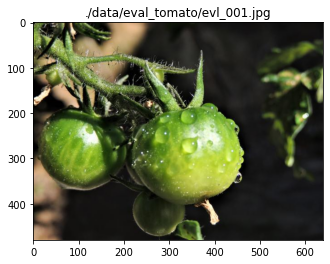

/content/mmdetection/mmdet/datasets/utils.py:70: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the document

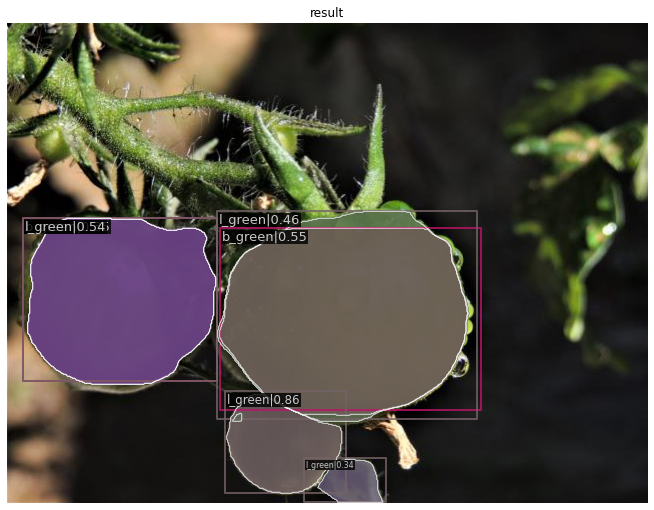

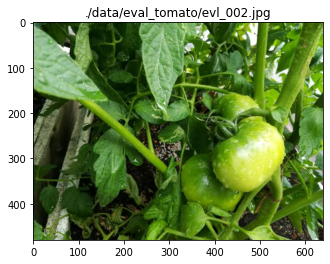

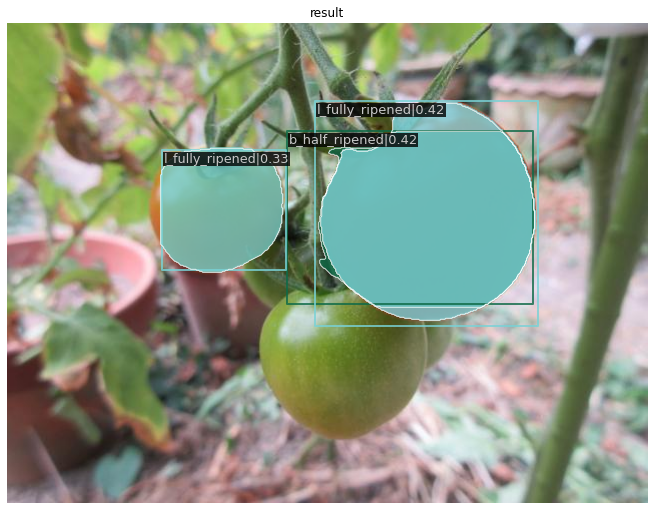

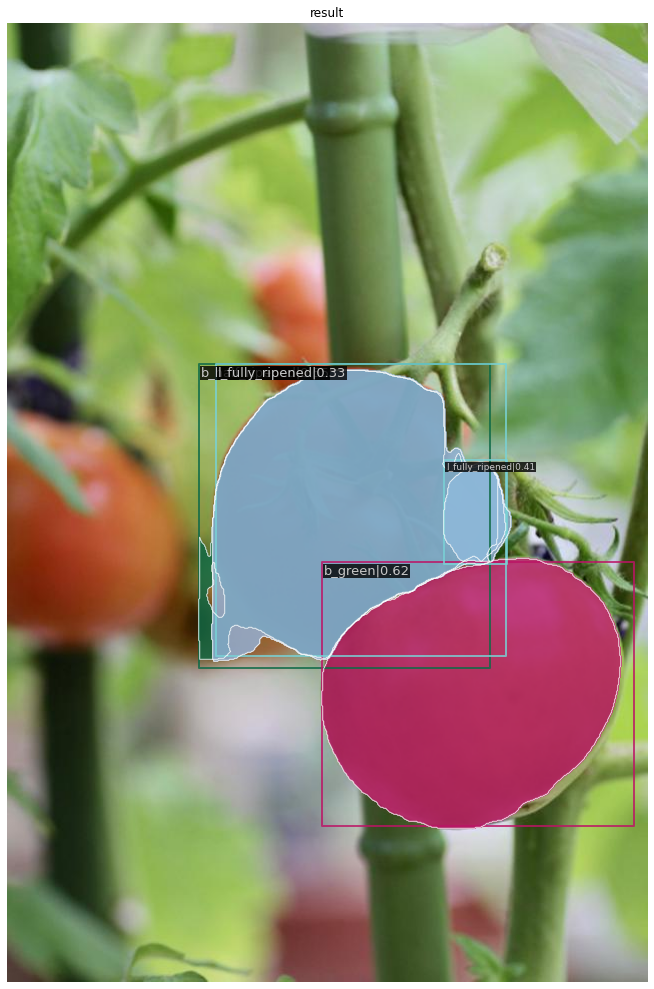

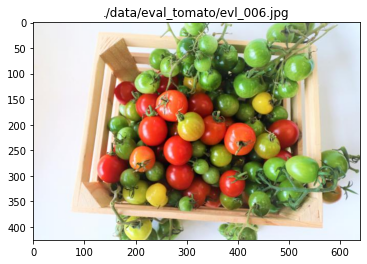

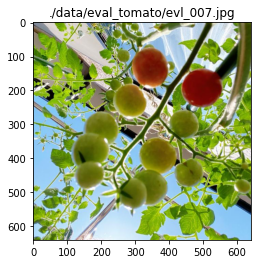

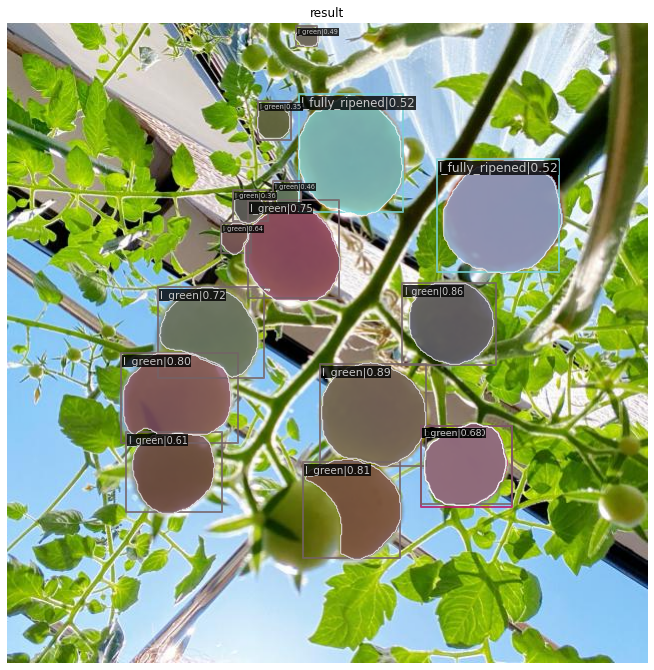

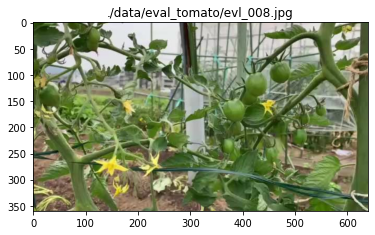

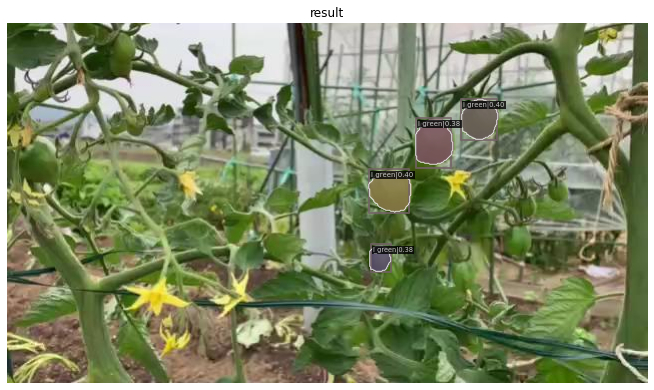

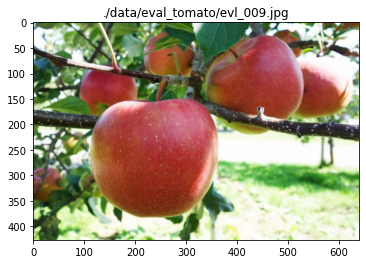

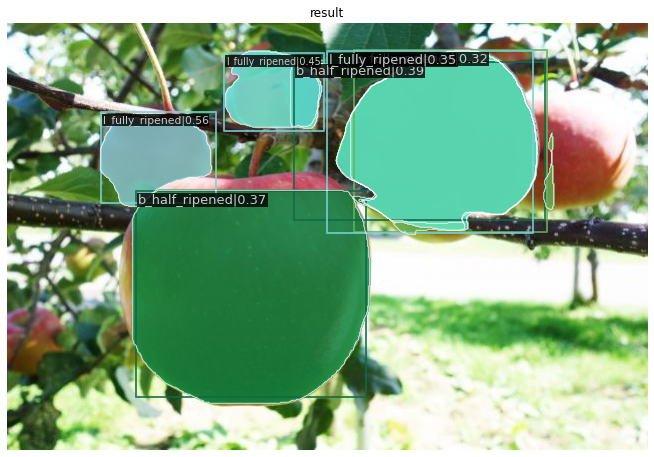

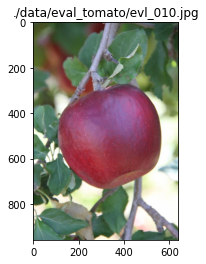

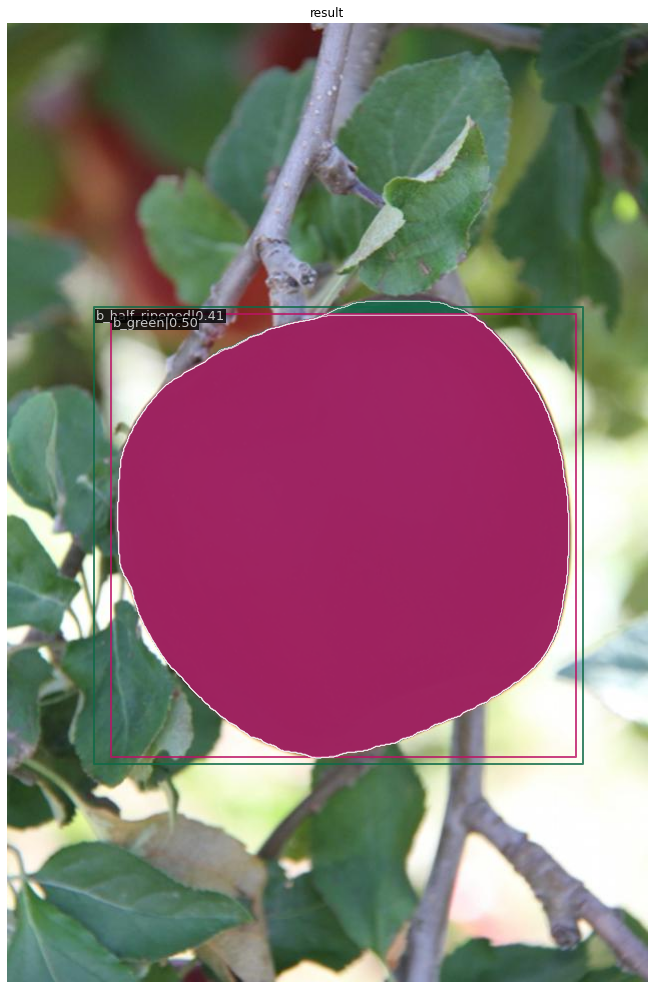

In [24]:
# 学習済みDetectorによる推定結果の評価
import mmcv
import matplotlib.pyplot as plt
import os
import glob
import pickle

!mkdir -p './data/eval_result/'
dst = './data/eval_result/'
src_imgs = sorted(glob.glob('./data/eval_tomato/*.jpg')) # オリジナル画像のパスと拡張子を設定

results = []

for i, f in enumerate(src_imgs):
    img = mmcv.imread(f) 
    # plt.figure(figsize=(10, 10))
    plt.title(str(f))
    plt.imshow(mmcv.bgr2rgb(img))
    plt.show()

    # 検出器での物体検出推定demo実行 
    # # Use the detector to do inference
    result = inference_detector(model, img)
    # Let's plot the result
    show_result_pyplot(model, img, result, score_thr=0.3)
    # save result data
    results.append(result)

# 推定・mask結果ファイルをpickle形式で保存
with open(dst+'results_yolact.bin', 'wb') as p:
    pickle.dump(dst+'results_yolact.bin', p)

In [ ]:
# 動画のセグメンテーション
# 動画データのロード 
!cd '/content/mmdetection'

# laboro_tomato datasetを./data/にシンボリックリンク
!mkdir -p ./data
!cp -Ri '/content/drive/MyDrive/Colab Notebooks/product_develop/video_tomato' './data'


In [26]:
# 動画セグメンテーション実行
src_movs = sorted(glob.glob('./data/video_tomato/*.mp4')) # オリジナル画像のパスと拡張子を設定


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')  

mov_name = 'tomato3.mp4'
out_file = dst+mov_name 
!python "./demo/video_demo.py" "./data/video_tomato/tomato3.mp4"\
        'configs/yolact/yolact_r50_1x8_coco_tomato_20220625-ep2.py'\
        'checkpoints/yolact_r50_1x8_coco_tomato_20220625-ep2.pth'\
        --out "./data/eval_result/tomato3_yolact.mp4"

load checkpoint from local path: checkpoints/yolact_r50_1x8_coco_tomato_20220625-ep2.pth
[                                                  ] 0/1752, elapsed: 0s, ETA:/content/mmdetection/mmdet/datasets/utils.py:70: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to a